In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        labels = []
        for i in range(num_objs):
            label = coco_annotation[i]["category_id"]
            labels.append(label)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# path to your own data and coco file
train_data_dir = "/content/drive/Shareddrives/Datattack (Free Meals)/train/data"
train_coco = "/content/drive/Shareddrives/Datattack (Free Meals)/train/data/labels_train.json"

# Batch size
train_batch_size = 1

# Params for dataloader
train_shuffle_dl = True
num_workers_dl = 4

# Params for training

# Two classes; Only target class or background
num_classes = 11
num_epochs = 2

lr = 0.005
momentum = 0.9
weight_decay = 0.005

In [ ]:
import torch


print("Torch version:", torch.__version__)

# create own Dataset
my_dataset = myOwnDataset(
    root=train_data_dir, annotation=train_coco, transforms= get_transform()
)

# own DataLoader
data_loader = torch.utils.data.DataLoader(
    my_dataset,
    batch_size=train_batch_size,
    shuffle=train_shuffle_dl,
    num_workers=num_workers_dl,
    collate_fn=collate_fn,
)


# select device (whether GPU or CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    # print(annotations)


model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=lr, momentum=momentum, weight_decay=weight_decay
)

len_dataloader = len(data_loader)

# Training
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}/{num_epochs}")
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # print(f"Iteration: {i}/{len_dataloader}, Loss: {losses}")

Torch version: 1.11.0+cu113
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# prediction = []
# i = 0
# for imgs, _ in data_loader:
#     i = i+1
#     imgs = list(img.to(device) for img in imgs)
#     prediction.append(model(imgs))
#     if i == 2:
#       break

In [ ]:
# print(prediction)

In [ ]:
from matplotlib import pyplot as plt
from torchvision.io import read_image
from pathlib import Path
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
import numpy as np
import torchvision.transforms.functional as F

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
img1_int = read_image(str(train_data_dir +'/'+ 'serialno_3a7db1dad930ea1ac9eb3e668371622dfe537651.png'))
# dog2_int = read_image(str(Path('assets') / 'dog2.jpg'))
img1_int = img1_int.to(device)

In [ ]:
batch_int = torch.stack([img1_int])
batch = convert_image_dtype(batch_int, dtype=torch.float)

outputs = model(batch)
print(outputs)

[{'boxes': tensor([[ 181.0242,  559.9020,  299.2323,  729.8631],
        [ 362.9894,  559.1174,  488.8940,  729.3142],
        [ 306.1118,  559.3206,  373.1306,  734.2726],
        [ 650.4301,  743.2885,  747.4457,  889.6746],
        [ 464.7899,  746.1475,  559.3658,  898.0854],
        [ 244.9030,  751.7028,  360.2042,  905.3780],
        [ 610.3237,  565.3739,  728.9944,  725.7665],
        [ 749.6656,  741.0953,  841.4733,  886.3982],
        [ 731.1615,  554.5381,  786.3681,  728.2938],
        [ 893.3475,  564.3101,  995.1149,  720.4203],
        [ 838.8574,  735.4051,  929.5352,  883.8871],
        [1088.6556,  557.8397, 1149.8914,  714.5010],
        [ 366.2988,  762.6301,  461.6920,  889.1008],
        [ 927.5154,  732.5477, 1015.2932,  877.8785],
        [ 789.5845,  560.5911,  894.2761,  721.6808],
        [ 501.3549,  570.8967,  608.8918,  721.7151],
        [1015.4589,  723.5215, 1101.0482,  869.5963],
        [ 557.9122,  744.2610,  654.7023,  889.2524],
        [ 987.524

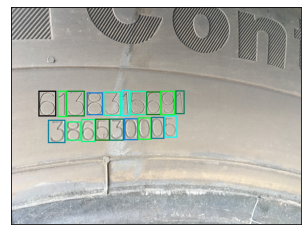

In [ ]:
score_threshold = .8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=8)
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

In [ ]:
score_threshold = .8
output = outputs[0]
indices = output['scores'] > score_threshold
print(indices)


tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False], device='cuda:0')


In [ ]:
boxes = np.array((output['boxes'][indices]).tolist())
labels = np.array((output['labels'][indices]).tolist())-1

In [ ]:
print(boxes)
print(labels)

[[ 181.02415466  559.90197754  299.23233032  729.86309814]
 [ 362.9894104   559.11743164  488.89398193  729.31420898]
 [ 306.11175537  559.32061768  373.13064575  734.27258301]
 [ 650.43005371  743.28851318  747.44567871  889.67456055]
 [ 464.78994751  746.14746094  559.36578369  898.08538818]
 [ 244.90304565  751.70275879  360.20422363  905.37799072]
 [ 610.32373047  565.37390137  728.9944458   725.76647949]
 [ 749.66564941  741.09533691  841.4732666   886.39819336]
 [ 731.16149902  554.53808594  786.36810303  728.29376221]
 [ 893.34753418  564.31005859  995.11486816  720.42028809]
 [ 838.85736084  735.40509033  929.53515625  883.88708496]
 [1088.65563965  557.83966064 1149.89135742  714.5010376 ]
 [ 366.29876709  762.63006592  461.69195557  889.10083008]
 [ 927.51538086  732.54766846 1015.29321289  877.878479  ]
 [ 789.58453369  560.59106445  894.27612305  721.68084717]
 [ 501.35488892  570.89666748  608.89178467  721.71508789]
 [1015.45892334  723.52148438 1101.04821777  869.5962524

In [ ]:
y_sort = boxes[:, 1].argsort()
box_sorted_asc = boxes[y_sort]
labels_sorted_asc = labels[y_sort]
print(box_sorted_asc)
print(labels_sorted_asc)

[[ 731.16149902  554.53808594  786.36810303  728.29376221]
 [1088.65563965  557.83966064 1149.89135742  714.5010376 ]
 [ 987.52398682  559.06719971 1086.18127441  721.82446289]
 [ 362.9894104   559.11743164  488.89398193  729.31420898]
 [ 306.11175537  559.32061768  373.13064575  734.27258301]
 [ 181.02415466  559.90197754  299.23233032  729.86309814]
 [ 789.58453369  560.59106445  894.27612305  721.68084717]
 [ 893.34753418  564.31005859  995.11486816  720.42028809]
 [ 610.32373047  565.37390137  728.9944458   725.76647949]
 [ 501.35488892  570.89666748  608.89178467  721.71508789]
 [1015.45892334  723.52148438 1101.04821777  869.59625244]
 [ 927.51538086  732.54766846 1015.29321289  877.878479  ]
 [ 838.85736084  735.40509033  929.53515625  883.88708496]
 [ 749.66564941  741.09533691  841.4732666   886.39819336]
 [ 650.43005371  743.28851318  747.44567871  889.67456055]
 [ 557.91217041  744.26098633  654.70227051  889.25238037]
 [ 464.78994751  746.14746094  559.36578369  898.0853881

In [ ]:
avg_y = np.array([0.5*(box[1]+box[3]) for box in box_sorted_asc])
avg_y

array([641.41592407, 636.17034912, 640.4458313 , 644.21582031,
       646.79660034, 644.88253784, 641.13595581, 642.36517334,
       645.57019043, 646.30587769, 796.55886841, 805.21307373,
       809.64608765, 813.74676514, 816.48153687, 816.75668335,
       822.11642456, 828.54037476, 825.865448  ])

In [ ]:
def split(arr, cond):
    return [arr[cond], arr[~cond]]

In [ ]:
is_first_row = avg_y<box_sorted_asc[0,3]
is_first_row

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [ ]:
fst_row, sec_row = split(labels_sorted_asc, is_first_row)
print(fst_row, sec_row)

[1 1 9 3 1 6 5 6 3 8] [5 0 0 0 3 5 6 3 8]


In [ ]:
fst_box, sec_box = split(box_sorted_asc, is_first_row)

In [ ]:
x_sort_first = fst_box[:, 0].argsort()

In [ ]:
first_label = fst_row[x_sort_first]
first_label

array([6, 1, 3, 8, 3, 1, 5, 6, 9, 1])

In [ ]:
row_1_str = "".join(map(str,first_label))
row_1_str

'6138315691'

In [ ]:
def out_to_str(output, thresh=0.8):
    def split(arr, cond):
      return [arr[cond], arr[~cond]]
    indices = output['scores'] > thresh
    boxes = np.array((output['boxes'][indices]).tolist())
    labels = np.array((output['labels'][indices]).tolist())-1
    y_sort = boxes[:, 1].argsort()
    box_sorted_asc = boxes[y_sort]
    labels_sorted_asc = labels[y_sort]
    avg_y = np.array([0.5*(box[1]+box[3]) for box in box_sorted_asc])

    is_first_row = avg_y<box_sorted_asc[0,3]
    fst_row, sec_row = split(labels_sorted_asc, is_first_row)
    fst_box, sec_box = split(box_sorted_asc, is_first_row)

    x_sort_first = fst_box[:, 0].argsort()
    first_label = fst_row[x_sort_first]
    row_1_str = "".join(map(str,first_label))

    x_sort_sec = sec_box[:, 0].argsort()
    sec_label = sec_row[x_sort_sec]
    row_2_str = "".join(map(str,sec_label))
    
    return row_1_str, row_2_str

In [ ]:
print(out_to_str(output))

('6138315691', '635613911')


In [ ]:
img2_int = read_image(str(train_data_dir +'/serialno_01f24d24300cb3233568af58718dbc4b748b5115.png'))
img2_int = img2_int.to(device)

In [ ]:
batch_int2 = torch.stack([img2_int])
batch2 = convert_image_dtype(batch_int2, dtype=torch.float)

outputs2 = model(batch2)

In [ ]:
print(out_to_str(outputs2[0]))

('6134866389', '')


In [3]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim


     |████████████████████████████████| 511.6 MB 10 kB/s 
     |████████████████████████████████| 438 kB 66.7 MB/s 
     |████████████████████████████████| 1.6 MB 57.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflo

     |████████████████████████████████| 352 kB 33.7 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [1]:
 df = pd.read_json('labels_train.json.', lines=True)
  
  model_path = os.path.join(weights_dir, f"{model_name}_continental.pt")
  model.load_state_dict(torch.load(model_path, map_location = device))
  #model_dir = pathlib.Path(model_dir)/"saved_model

NameError: ignored

In [ ]:
from keras_retinanet.models import load_model
model = load_model('/path/to/model.h5', backbone_name='resnet50')

In [10]:
def load_model(model_name):
  base_url = "/content/drive/Shareddrives/Datattack (Free Meals)/train/data/labels_train.json"
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)


  model_path = os.path.join(weights_dir, f"{model_name}_continental.pt")
  model.load_state_dict(torch.load(model_path, map_location = device))
  #model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

NameError: ignored